### Quick Start

The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

#### Basic Tutorial

In [1]:
# Load necessary packages
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch

passing 1
wandb not available
wandb not available


#### Generate Training Data
First we need to generate some training data. As mentioned above we will do so using the `ssms` python package, however without delving into a detailed explanation
of this package. Please refer to the [basic ssms tutorial] (https://github.com/AlexanderFengler/ssm_simulators) in case you want to learn more.

In [2]:
# MAKE CONFIGS
model = 'ddm_deadline'
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = model
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 16384
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 1000
# Specify folder in which to save generated data
generator_config["output_folder"] = "data/lan_mlp/" + model + "/"

# Make model config dict
model_config = ssms.config.model_config[model.split('_deadline')[0]]

In [4]:
# MAKE DATA

my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
    generator_config=generator_config, model_config=model_config
)

for i in range(25):
    print(i)
    training_data = my_dataset_generator.generate_data_training_uniform(save=True)

{'name': 'angle_deadline', 'params': ['v', 'a', 'z', 't', 'theta', 'deadline'], 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1, 0.001], [3.0, 3.0, 0.9, 2.0, 1.3, 10]], 'boundary_name': 'angle', 'boundary': <function angle at 0x107a4e9e0>, 'n_params': 6, 'default_params': [0.0, 1.0, 0.5, 0.001, 0.0, 10], 'nchoices': 2, 'simulator': <cyfunction ddm_flexbound at 0x1279ea4d0>}
n_cpus used:  12
checking:  data/lan_mlp/angle_deadline/
0
simulation round: 1  of 10


simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  data/lan_mlp/angle_deadline//training_data_abc6f960c0a511eea6f86ae25f443f62.pickle
1
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  data/lan_mlp/angle_deadline//training_data_e70570ecc0a511eea6f86ae25f443f62.pickle
2
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing 

In [ ]:
#training_data

'Dataset completed'

#### Prepare for Training

Next we set up dataloaders for training with pytorch. The `LANfactory` uses custom dataloaders, taking into account particularities of the expected training data.
Specifically, we expect to receive a bunch of training data files (the present example generates only one), where each file hosts a large number of training examples. 
So we want to define a dataloader which spits out batches from data with a specific training data file, and keeps checking when to load in a new file. 
The way this is implemented here, is via the `DatasetTorch` class in `lanfactory.trainers`, which inherits from `torch.utils.data.Dataset` and prespecifies a `batch_size`. Finally this is supplied to a [`DataLoader`](https://pytorch.org/docs/stable/data.html), for which we keep the `batch_size` argument at 0.

The `DatasetTorch` class is then called as an iterator via the DataLoader and takes care of batching as well as file loading internally. 

You may choose your own way of defining the `DataLoader` classes, downstream you are simply expected to supply one.

In [3]:
# MAKE DATALOADERS

# List of datafiles (here only one)
folder_ = "data/lan_mlp/" + model + "/" # + "/training_data_0_nbins_0_n_1000/"
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)]
feature_key = "gonogo_data"
label_key = "gonogo_labels"

# Training dataset
torch_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_, batch_size=2048, features_key=feature_key,
        label_key=label_key,
)

torch_training_dataloader = torch.utils.data.DataLoader(
    torch_training_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

# Validation dataset
torch_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_, batch_size=2048, features_key=feature_key,
        label_key=label_key,
)

torch_validation_dataloader = torch.utils.data.DataLoader(
    torch_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

Now we define two configuration dictionariers,

1. The `network_config` dictionary defines the architecture and properties of the network
2. The `train_config` dictionary defines properties concerning training hyperparameters

Two examples (which we take as provided by the package, but which you can adjust according to your needs) are provided below.

In [4]:
# SPECIFY NETWORK CONFIGS AND TRAINING CONFIGS
network_type = "gonogo"
if network_type == "cpn":
    network_config = lanfactory.config.network_configs.network_config_cpn
    train_config = lanfactory.config.network_configs.train_config_cpn
elif network_type == "lan":
    network_config = lanfactory.config.network_configs.network_config_mlp
    train_config = lanfactory.config.network_configs.train_config_mlp
elif network_type == "opn":
    network_config = lanfactory.config.network_configs.network_config_cpn
    train_config = lanfactory.config.network_configs.train_config_cpn
elif network_type == "gonogo":
    network_config = lanfactory.config.network_configs.network_config_cpn
    train_config = lanfactory.config.network_configs.train_config_cpn

print("Network config: ")
print(network_config)

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logits'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'bcelogit', 'save_history': True}


We can now load a network, and save the configuration files for convenience.

In [5]:
# LOAD NETWORK

network_config["layer_sizes"] = [100, 100, 100, 100, 1]
network_config["activations"] = ["tanh", "tanh", "tanh","tanh", "linear"]

net = lanfactory.trainers.TorchMLP(
    network_config=deepcopy(network_config),
    input_shape=torch_training_dataset.input_dim,
    save_folder="data/torch_models/" + model + "/",
    generative_model_id="angle_deadline",
)

# SAVE CONFIGS
lanfactory.utils.save_configs(
    model_id="angle" + "_torch_",
    save_folder="data/torch_models/" + model + "/",
    network_config=network_config,
    train_config=train_config,
    allow_abs_path_folder_generation=True,
)

tanh
tanh
tanh
tanh
linear
Found folder:  data
Moving on...
Found folder:  data/torch_models
Moving on...
Found folder:  data/torch_models/ddm_deadline
Moving on...
Saved network config
Saved train config


To finally train the network we supply our network, the dataloaders and training config to the `ModelTrainerTorchMLP` class, from `lanfactory.trainers`.

In [6]:
# TRAIN MODEL
n_epochs = 20
train_config["n_epochs"] = n_epochs

model_trainer = lanfactory.trainers.ModelTrainerTorchMLP(
                        model=net,
                        train_config=train_config,
                        train_dl=torch_training_dataloader,
                        valid_dl=torch_validation_dataloader,
                        allow_abs_path_folder_generation=False,
                        pin_memory=True,
                        seed = None,
                    )

# model_trainer.train_model(save_history=True, save_model=True, verbose=0)
model_trainer.train_and_evaluate(wandb_on = False,
                                 output_folder = 'data/torch_models/' + model + "_gonogo" + '/',
                                 output_file_id = model)
# LOAD MODEL

Torch Device:  cpu
Found folder:  data
Moving on...
Found folder:  data/torch_models
Moving on...
Found folder:  data/torch_models/ddm_deadline_gonogo
Moving on...
passing 1
wandb not available
wandb not available
epoch: 0 / 20, batch: 0 / 200, batch_loss: 0.6920046210289001
epoch: 0 / 20, batch: 100 / 200, batch_loss: 0.36131706833839417
Epoch took 0 / 20,  took 12.086654901504517 seconds
passing 1
wandb not available
wandb not available
epoch 0 / 20, validation_loss: 0.367
passing 1
wandb not available
wandb not available
epoch: 1 / 20, batch: 0 / 200, batch_loss: 0.36805611848831177
epoch: 1 / 20, batch: 100 / 200, batch_loss: 0.36658111214637756
Epoch took 1 / 20,  took 11.953201055526733 seconds
passing 1
wandb not available
wandb not available
epoch 1 / 20, validation_loss: 0.3627
passing 1
wandb not available
wandb not available
epoch: 2 / 20, batch: 0 / 200, batch_loss: 0.35565024614334106
epoch: 2 / 20, batch: 100 / 200, batch_loss: 0.35800328850746155
Epoch took 2 / 20,  took

#### Load Model for Inference and Call

The `LANfactory` provides some convenience functions to use networks for inference after training. 
We can load a model using the `LoadTorchMLPInfer` class, which then allows us to run fast inference via either
a direct call, which expects a `torch.tensor` as input, or the `predict_on_batch` method, which expects a `numpy.array` 
of `dtype`, `np.float32`. 

In [7]:
network_path_list = os.listdir("data/torch_models/" + model + "_gonogo" + "/")
network_file_path = [
    "data/torch_models/" + model + "_gonogo" + "/" + file_
    for file_ in network_path_list
    if "state_dict" in file_
][0]

network = lanfactory.trainers.LoadTorchMLPInfer(
    model_file_path=network_file_path,
    network_config=network_config,
    input_dim=torch_training_dataset.input_dim,
)

tanh
tanh
tanh
tanh
linear


In [12]:
network_file_path

'data/torch_models/angle_deadline_gonogo/angle_deadline_cpn_runid_train_state_dict_torch.pt'

In [8]:
# Two ways to call the network

# Direct call --> need tensor input
direct_out = network(
    torch.from_numpy(np.array([1, 1.5, 0.5, 1.0, 1], dtype=np.float32))
)
print("direct call out: ", direct_out)

# predict_on_batch method
predict_on_batch_out = network.predict_on_batch(
    np.array([1, 1.5, 0.5, 1.0, 1], dtype=np.float32)
)
print("predict_on_batch out: ", predict_on_batch_out)

direct call out:  tensor([-0.0048])
predict_on_batch out:  [-0.00479465]


#### A peek into the first passage distribution computed by the network

We can compare the learned likelihood function in our `network` with simulation data from the underlying generative model.
For this purpose we recruit the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package again.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from ssms.basic_simulators.simulator import simulator

data = pd.DataFrame(
    np.zeros((2000, 5), dtype=np.float32),
    columns=["v", "a", "z", "t", "deadline"],
)
data["v"] = np.linspace(-3., 3., 2000)
data["a"] = 1.5
data["z"] = 0.5
data["t"] = 0.2
# data["theta"] = 0.1
data["deadline"] = 2.

# Network predictions
network_predictions = []


# Simulations
choice_p_vec = np.zeros((20,40)) # np.zeros(20, 20)
for i, deadline in enumerate(np.linspace(0.5, 2.5, 20)):
    data["v"] = np.linspace(-3., 3., 2000)
    data["deadline"] = deadline
    network_predictions.append(network.predict_on_batch(data[['v', 'a', 'z', 't', 'deadline']].values.astype(np.float32)))
    for j, v in enumerate(np.linspace(-3., 3., 40)):
        data["v"] = v
        sim_out = simulator(model=model, 
                            theta=data[['v', 'a', 'z', 't', 'deadline']].values[0, :], 
                            n_samples=5000)
        choice_p_vec[i, j] = sim_out["nogo_p"][0, 0]

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_ssm_simulators/ssm-simulators/ssms/basic_simulators/simulator.py:399: UserWarning: Deadline model request, and theta not supplied as dict.Make sure to supply the deadline parameters in last position!
  warnings.warn(
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_ssm_simulators/ssm-simulators/ssms/basic_simulators/simulator.py:399: UserWarning: Deadline model request, and theta not supplied as dict.Make sure to supply the deadline parameters in last position!
  warnings.warn(
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_ssm_simulators/ssm-simulators/ssms/basic_simulators/simulator.py:399: UserWarning: Deadline model request, and theta not supplied as dict.Make sure to supply the deadline parameters in last position!
  warnings.warn(
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_ssm_simulators/ssm-simulators/ssms/basic_simulators/simulator.py:399: UserWarning: Deadline model request, an

Text(0, 0.5, 'nogo_p')

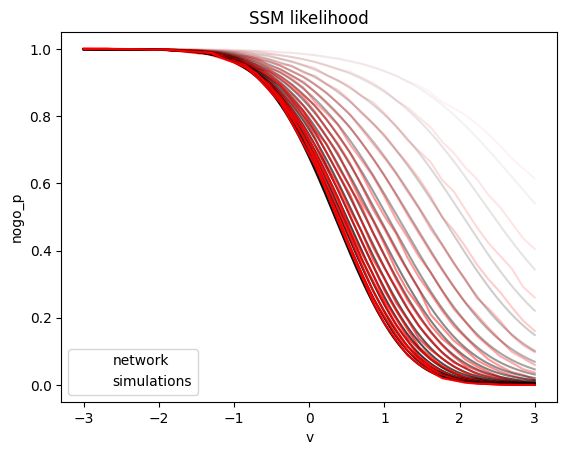

In [11]:
# Plot network predictions
from cProfile import label

# Plot simulations
for i in range(20):

    plt.plot(
        np.linspace(-3, 3, 2000),
        np.exp(network_predictions[i]),
        color="black",
        label=None if i > 0 else "network",
        alpha = i/20,
    )

    plt.plot(
        np.linspace(-3, 3, 40),
        np.array(choice_p_vec[i, :]),
        color="red",
        label=None if i > 0 else "simulations",
        alpha = i/20,
    )

plt.legend()
plt.title("SSM likelihood")
plt.xlabel("v")
plt.ylabel("nogo_p")

We hope this package may be helpful in case you attempt to train [LANs](https://elifesciences.org/articles/65074) for your own research.

#### END